# Solar Power Forecasting for Power Systems

## Introduction

Solar power generation has become a critical component of modern power systems. As solar capacity increases, accurate forecasting becomes essential for grid operators to maintain system reliability and economic efficiency. Unlike conventional generators, solar power output depends on weather conditions, making it inherently variable and challenging to predict.

This lesson introduces practical forecasting techniques specifically designed for solar power generation. We'll explore statistical and machine learning approaches, analyze their strengths and limitations, and understand how to interpret forecast results for operational decision-making.

## Learning Objectives

By the end of this lesson, you will be able to:

1. Understand the unique characteristics of solar power generation data
2. Apply time series forecasting methods (ARIMA) to solar power data
3. Implement advanced forecasting with Prophet for handling seasonality
4. Use machine learning (LightGBM) with feature engineering for improved accuracy
5. Evaluate and compare different forecasting methods
6. Interpret feature importance for model explainability
7. Select appropriate forecasting methods based on data characteristics

## Prerequisites

This lesson builds on:
- Python fundamentals (Module 1)
- NumPy and Pandas basics (Module 2)
- Time series analysis concepts (previous lessons in Module 2)
- Basic understanding of solar power generation

## Why Solar Power Forecasting Matters

Solar power forecasting addresses several critical challenges in power system operations:

1. **Unit Commitment**: Conventional generators need advance notice to start up or shut down
2. **Reserve Planning**: System operators must maintain adequate reserves to compensate for solar variability
3. **Economic Dispatch**: Accurate forecasts enable optimal scheduling of generation resources
4. **Ramp Management**: Predicting sunrise/sunset and cloud-induced ramps helps prevent system instability

The dataset we'll use represents a 118 MW solar farm in Mississippi, providing realistic patterns for analysis.

## 1. Setup and Data Loading

Let's begin by importing the necessary libraries and loading our solar generation data. We'll use a comprehensive set of libraries for time series analysis, statistical modeling, and machine learning.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Install required packages if not already installed
!{sys.executable} -m pip install statsmodels scikit-learn --quiet

# Time series analysis tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Set display options for better readability
pd.set_option('display.max_rows', 10)
pd.set_option('display.precision', 2)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully")
print(f"Pandas version: {pd.__version__}")

Libraries loaded successfully
Pandas version: 2.3.1


### Loading and Understanding the Data

Our dataset contains 5-minute resolution solar power output data from a 118 MW solar farm in Mississippi for the entire year 2006. This high-resolution data captures rapid changes due to cloud cover and provides excellent training material for forecasting models.

In [2]:
# Load the solar generation data
current_dir = os.getcwd()
csv_path = os.path.join(current_dir, "ms-pv-2006", "Actual_30.25_-89.45_2006_UPV_118MW_5_Min.csv")

# Read the data
df = pd.read_csv(csv_path)

# Create a proper datetime index
df['Datetime'] = pd.to_datetime(df['LocalTime'], format='%m/%d/%y %H:%M')
df.set_index('Datetime', inplace=True)

# Display basic information about the dataset
print("Dataset Information:")
print(f"Time period: {df.index[0]} to {df.index[-1]}")
print(f"Number of observations: {len(df):,}")
print(f"Time resolution: 5 minutes")
print(f"Maximum capacity: 118 MW")
print(f"\nActual maximum output: {df['Power(MW)'].max():.1f} MW")
print(f"Capacity factor: {(df['Power(MW)'].mean() / 118 * 100):.1f}%")

# Show sample of the data
print("\nSample data (noon on a summer day):")
print(df.loc['2006-07-15 11:00':'2006-07-15 13:00'])

Dataset Information:
Time period: 2006-01-01 00:00:00 to 2006-12-31 23:55:00
Number of observations: 105,120
Time resolution: 5 minutes
Maximum capacity: 118 MW

Actual maximum output: 99.0 MW
Capacity factor: 19.0%

Sample data (noon on a summer day):
                          LocalTime  Power(MW)
Datetime                                      
2006-07-15 11:00:00  07/15/06 11:00       41.3
2006-07-15 11:05:00  07/15/06 11:05       52.5
2006-07-15 11:10:00  07/15/06 11:10       58.4
2006-07-15 11:15:00  07/15/06 11:15       54.0
2006-07-15 11:20:00  07/15/06 11:20       60.9
...                             ...        ...
2006-07-15 12:40:00  07/15/06 12:40       41.9
2006-07-15 12:45:00  07/15/06 12:45       34.1
2006-07-15 12:50:00  07/15/06 12:50       63.6
2006-07-15 12:55:00  07/15/06 12:55       74.9
2006-07-15 13:00:00  07/15/06 13:00       71.9

[25 rows x 2 columns]


## 2. Exploratory Data Analysis

Before building forecasting models, it's crucial to understand the patterns in solar generation data. Solar power exhibits distinct characteristics:

1. **Daily Seasonality**: Zero output at night, peak around solar noon
2. **Weather Dependence**: Cloud cover causes rapid fluctuations
3. **Seasonal Variations**: Higher output in summer due to longer days and sun angle
4. **Ramp Rates**: Fast changes during sunrise/sunset and cloud events

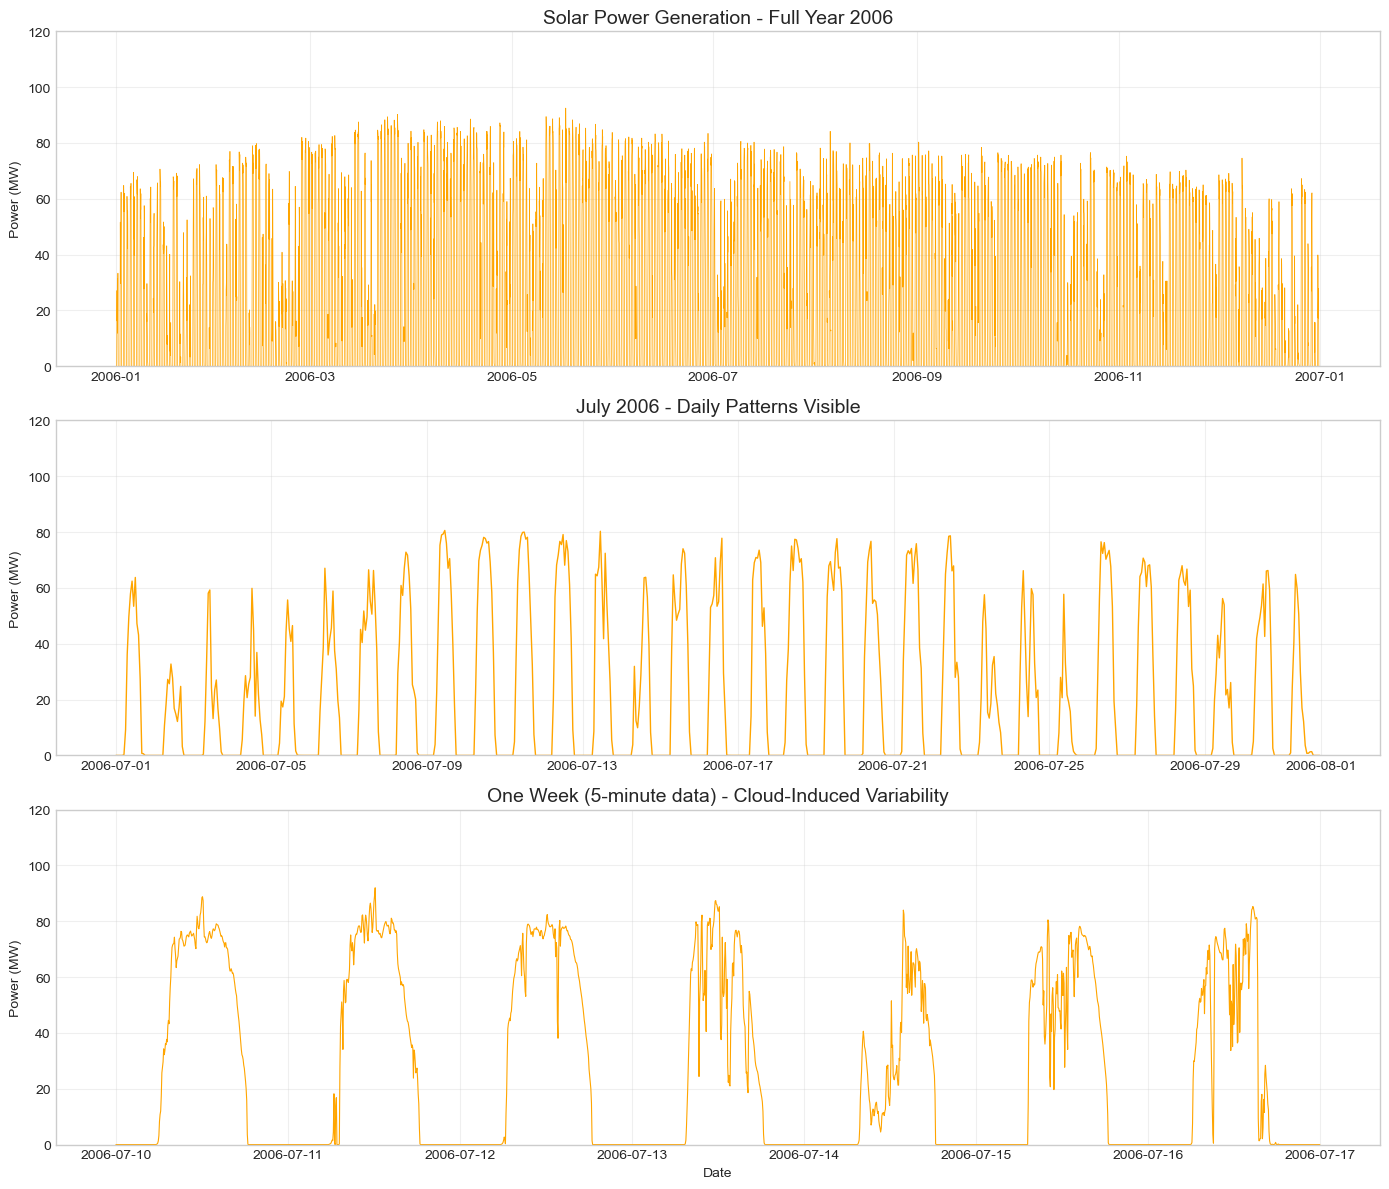


Solar Generation Statistics:
Average daytime output (6 AM - 6 PM): 41.2 MW
Average nighttime output: 0.1 MW
Standard deviation (5-min): 29.6 MW
Maximum 5-minute ramp: 53.5 MW


In [3]:
# Resample to hourly data for clearer visualization
# We'll use both 5-minute and hourly data depending on the analysis
hourly_data = df['Power(MW)'].resample('H').mean()

# Create multi-panel visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Panel 1: Full year overview
ax = axes[0]
ax.plot(hourly_data.index, hourly_data.values, linewidth=0.5, color='orange')
ax.set_title('Solar Power Generation - Full Year 2006', fontsize=14)
ax.set_ylabel('Power (MW)')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 120)

# Panel 2: One month detail (July)
ax = axes[1]
july_data = hourly_data['2006-07']
ax.plot(july_data.index, july_data.values, linewidth=1, color='orange')
ax.set_title('July 2006 - Daily Patterns Visible', fontsize=14)
ax.set_ylabel('Power (MW)')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 120)

# Panel 3: One week with 5-minute data to show variability
ax = axes[2]
week_data = df['Power(MW)']['2006-07-10':'2006-07-16']
ax.plot(week_data.index, week_data.values, linewidth=0.8, color='orange')
ax.set_title('One Week (5-minute data) - Cloud-Induced Variability', fontsize=14)
ax.set_ylabel('Power (MW)')
ax.set_xlabel('Date')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 120)

plt.tight_layout()
plt.show()

# Calculate and display key statistics
print("\nSolar Generation Statistics:")
print(f"Average daytime output (6 AM - 6 PM): {df[(df.index.hour >= 6) & (df.index.hour <= 18)]['Power(MW)'].mean():.1f} MW")
print(f"Average nighttime output: {df[(df.index.hour < 6) | (df.index.hour > 18)]['Power(MW)'].mean():.1f} MW")
print(f"Standard deviation (5-min): {df['Power(MW)'].std():.1f} MW")
print(f"Maximum 5-minute ramp: {df['Power(MW)'].diff().abs().max():.1f} MW")

### Analyzing Seasonal Patterns

Solar generation varies significantly throughout the year due to changing sun angles and daylight hours. Let's examine these seasonal patterns:

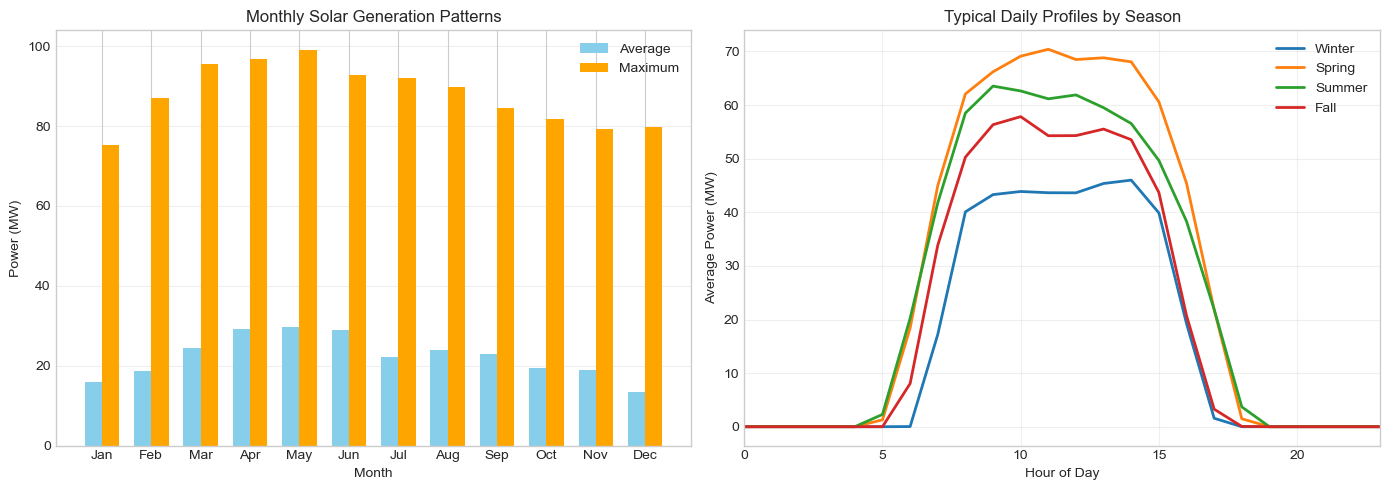

In [4]:
# Calculate monthly statistics
monthly_stats = df.groupby(df.index.month)['Power(MW)'].agg(['mean', 'max', 'std'])
monthly_stats.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create seasonal analysis plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Monthly average and maximum
x = np.arange(len(monthly_stats))
width = 0.35

bars1 = ax1.bar(x - width/2, monthly_stats['mean'], width, label='Average', color='skyblue')
bars2 = ax1.bar(x + width/2, monthly_stats['max'], width, label='Maximum', color='orange')

ax1.set_xlabel('Month')
ax1.set_ylabel('Power (MW)')
ax1.set_title('Monthly Solar Generation Patterns')
ax1.set_xticks(x)
ax1.set_xticklabels(monthly_stats.index)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Typical daily profile by season
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

for season, months in seasons.items():
    season_data = df[df.index.month.isin(months)]
    hourly_profile = season_data.groupby(season_data.index.hour)['Power(MW)'].mean()
    ax2.plot(hourly_profile.index, hourly_profile.values, linewidth=2, label=season)

ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Average Power (MW)')
ax2.set_title('Typical Daily Profiles by Season')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 23)

plt.tight_layout()
plt.show()

## 3. Time Series Forecasting with ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a classical statistical method for time series forecasting. While it has limitations for solar data due to the strong daily seasonality and zero nighttime values, it provides a good baseline and helps us understand the challenges of solar forecasting.

### Understanding ARIMA Components:
- **AR (p)**: Uses past values to predict future values
- **I (d)**: Differencing to achieve stationarity
- **MA (q)**: Uses past forecast errors

For solar data, we need to carefully consider:
1. The data is not stationary (has clear patterns)
2. Nighttime zeros create discontinuities
3. Weather-driven variability is not captured by historical patterns alone

Stationarity Test Results:
ADF Statistic: -9.8020
p-value: 0.0000
Critical values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

Series is stationary


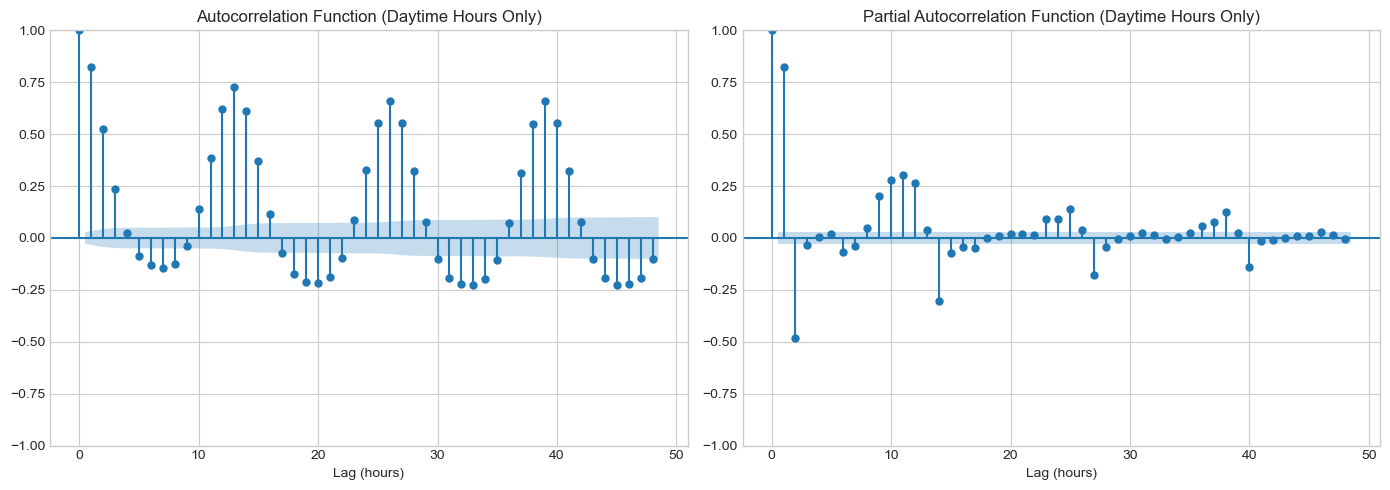

In [5]:
# Prepare data for ARIMA
# Use hourly data to reduce computational complexity
arima_data = hourly_data.copy()

# Check stationarity with Augmented Dickey-Fuller test
print("Stationarity Test Results:")
result = adfuller(arima_data.dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Critical values:")
for key, value in result[4].items():
    print(f"  {key}: {value:.3f}")

if result[1] > 0.05:
    print("\nSeries is non-stationary (as expected for solar data)")
else:
    print("\nSeries is stationary")

# Visualize ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Focus on daytime hours for more meaningful patterns
daytime_data = arima_data[(arima_data.index.hour >= 6) & (arima_data.index.hour <= 18)]

plot_acf(daytime_data.dropna(), lags=48, ax=ax1)
ax1.set_title('Autocorrelation Function (Daytime Hours Only)')
ax1.set_xlabel('Lag (hours)')

plot_pacf(daytime_data.dropna(), lags=48, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (Daytime Hours Only)')
ax2.set_xlabel('Lag (hours)')

plt.tight_layout()
plt.show()

### Fitting and Evaluating ARIMA Model

Let's fit an ARIMA model and evaluate its performance. We'll use a grid search to find optimal parameters, but keep in mind that ARIMA's assumptions don't align well with solar data characteristics.

In [6]:
# Split data for training and testing
train_size = int(len(arima_data) * 0.8)
train, test = arima_data[:train_size], arima_data[train_size:]

print(f"Training period: {train.index[0]} to {train.index[-1]}")
print(f"Testing period: {test.index[0]} to {test.index[-1]}")
print(f"Test set size: {len(test)} hours")

# Simplified grid search for ARIMA parameters
# Note: Full grid search is computationally intensive
print("\nSearching for optimal ARIMA parameters...")

# Try a few parameter combinations
p_values = [1, 2]
d_values = [0, 1]
q_values = [1, 2]

best_aic = float('inf')
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")

# Fit the best model
model = ARIMA(train, order=best_order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Calculate error metrics
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f"\nARIMA Model Performance:")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAPE: {mape:.2f}%")

Training period: 2006-01-01 00:00:00 to 2006-10-19 23:00:00
Testing period: 2006-10-20 00:00:00 to 2006-12-31 23:00:00
Test set size: 1752 hours

Searching for optimal ARIMA parameters...
Best ARIMA order: (2, 0, 2) with AIC: 52351.14

ARIMA Model Performance:
MAE: 23.56 MW
RMSE: 25.34 MW
MAPE: inf%


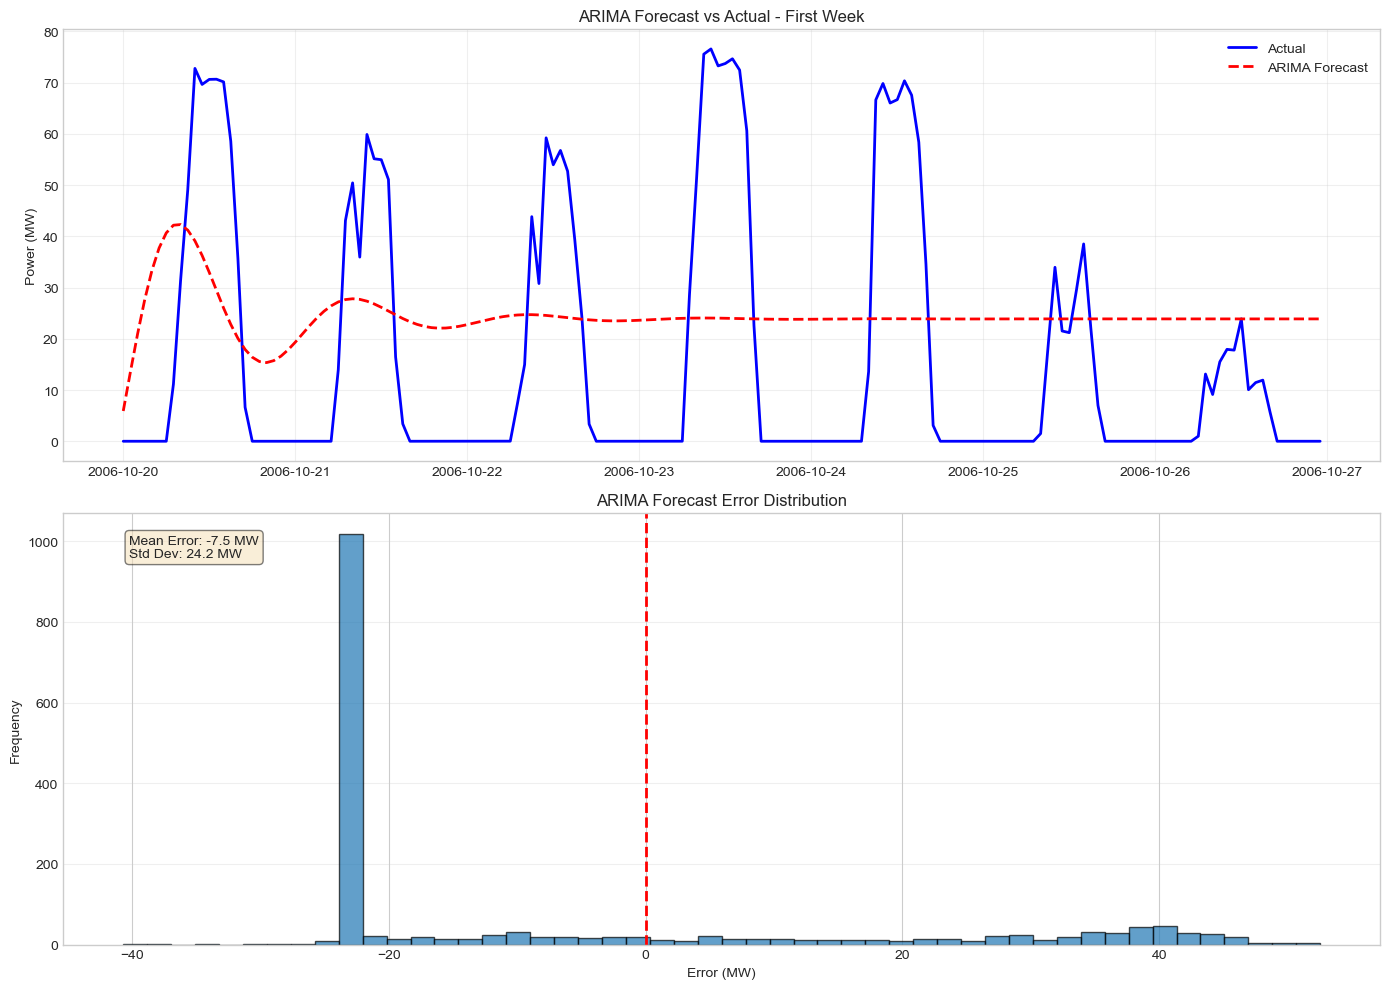


ARIMA Limitations for Solar Forecasting:
- Struggles with the daily seasonality and zero nighttime values
- Cannot capture weather-driven variability
- Tends to converge to mean values for longer horizons
- Better suited for data with consistent patterns


In [7]:
# Visualize ARIMA predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: First week of predictions
week_start = test.index[0]
week_end = week_start + pd.Timedelta(days=7)
week_mask = (test.index >= week_start) & (test.index < week_end)

ax1.plot(test[week_mask].index, test[week_mask].values, 'b-', linewidth=2, label='Actual')
ax1.plot(test[week_mask].index, predictions[week_mask], 'r--', linewidth=2, label='ARIMA Forecast')
ax1.set_title('ARIMA Forecast vs Actual - First Week')
ax1.set_ylabel('Power (MW)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error distribution
errors = test - predictions
ax2.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_title('ARIMA Forecast Error Distribution')
ax2.set_xlabel('Error (MW)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3, axis='y')

# Add text with statistics
textstr = f'Mean Error: {errors.mean():.1f} MW\nStd Dev: {errors.std():.1f} MW'
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nARIMA Limitations for Solar Forecasting:")
print("- Struggles with the daily seasonality and zero nighttime values")
print("- Cannot capture weather-driven variability")
print("- Tends to converge to mean values for longer horizons")
print("- Better suited for data with consistent patterns")

## 4. Advanced Forecasting with Prophet

Prophet is a forecasting library developed by Meta (Facebook) that excels at handling time series with strong seasonal patterns and holiday effects. It's particularly well-suited for solar power forecasting because:

1. **Handles multiple seasonalities**: Daily and yearly patterns
2. **Robust to missing data**: Common in real-world solar datasets
3. **Automatic changepoint detection**: Adapts to trend changes
4. **Uncertainty intervals**: Provides confidence bands for forecasts

Let's implement Prophet for our solar forecasting task.

In [8]:
# Install Prophet if not already installed
!{sys.executable} -m pip install prophet --quiet

from prophet import Prophet

# Prepare data for Prophet
# Prophet requires specific column names: 'ds' for timestamp and 'y' for values
prophet_data = pd.DataFrame({
    'ds': hourly_data.index,
    'y': hourly_data.values
})

# Split data
split_date = '2006-10-01'
train_prophet = prophet_data[prophet_data['ds'] < split_date]
test_prophet = prophet_data[prophet_data['ds'] >= split_date]

print(f"Prophet training data: {len(train_prophet)} hours")
print(f"Prophet test data: {len(test_prophet)} hours")

# Initialize and fit Prophet model
print("\nFitting Prophet model...")
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative',  # Better for solar data
    interval_width=0.95,
    changepoint_prior_scale=0.05  # More flexible trend
)

# Fit the model
model_prophet.fit(train_prophet)

# Make future dataframe for predictions
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='H')
forecast = model_prophet.predict(future)

# Extract test period forecasts
test_forecast = forecast[forecast['ds'] >= split_date].copy()

print("Prophet model fitted successfully")

Importing plotly failed. Interactive plots will not work.


Prophet training data: 6552 hours
Prophet test data: 2208 hours

Fitting Prophet model...


22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted successfully


Prophet Model Performance:
MAE: 26.20 MW
RMSE: 32.23 MW
MAPE (daytime only): 2904.32%


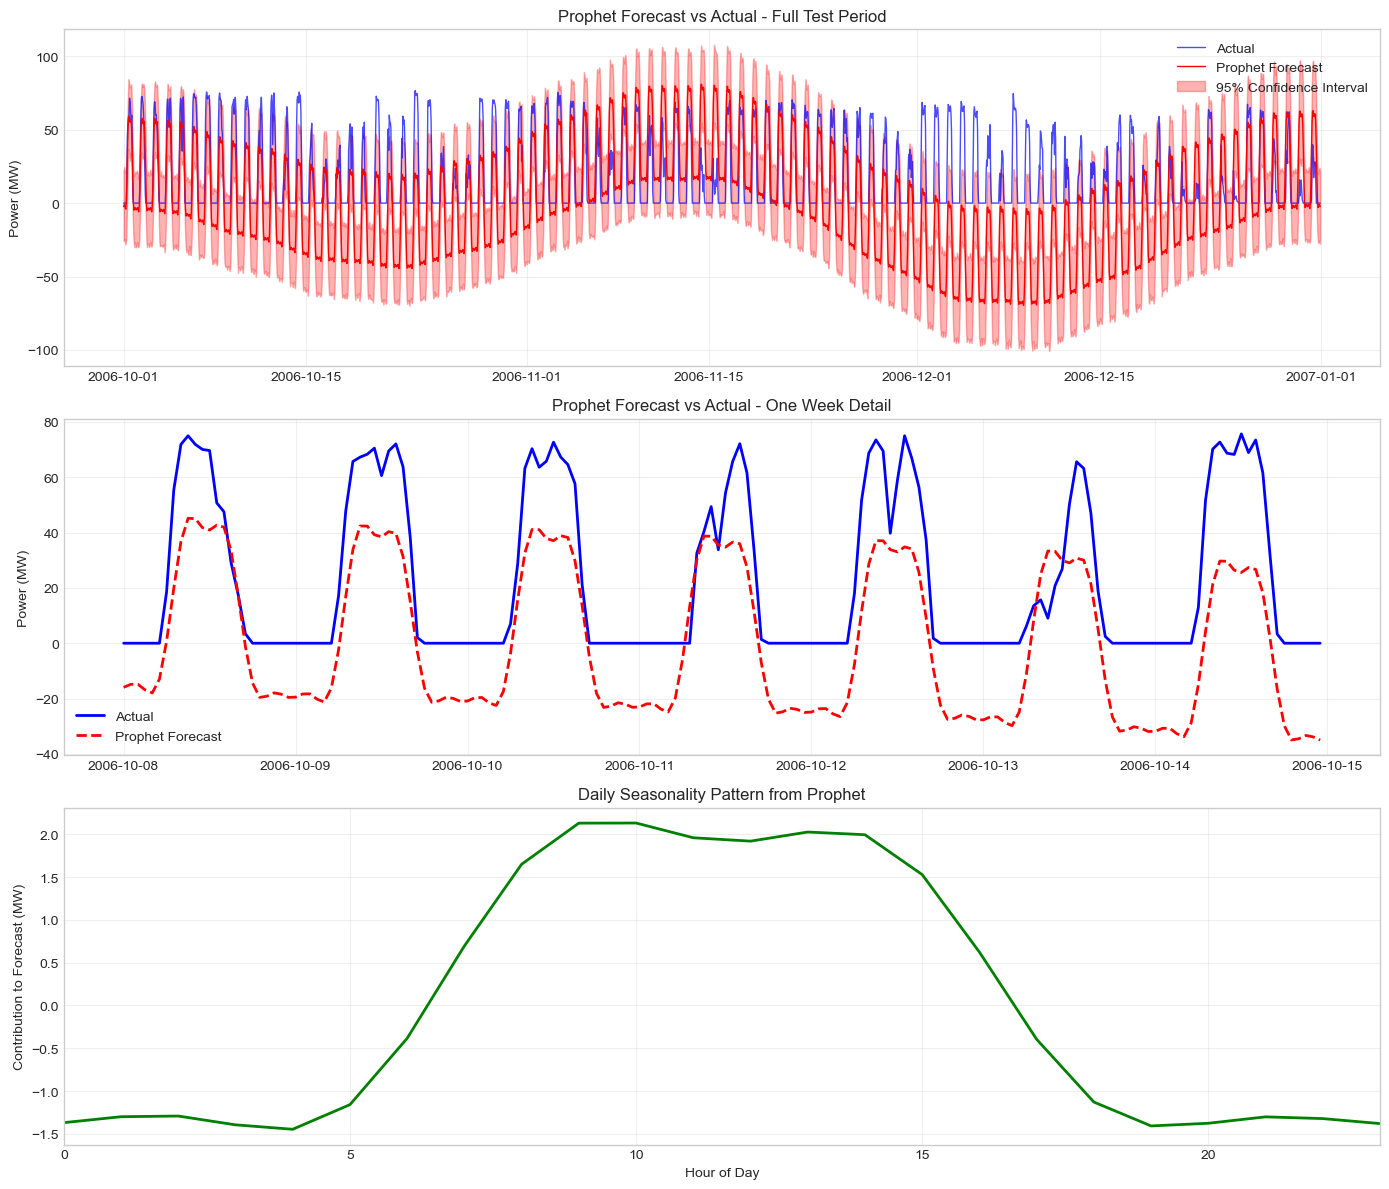

In [9]:
# Evaluate Prophet performance
prophet_predictions = test_forecast['yhat'].values[:len(test_prophet)]
actual_values = test_prophet['y'].values

# Calculate metrics
mae_prophet = mean_absolute_error(actual_values, prophet_predictions)
rmse_prophet = np.sqrt(mean_squared_error(actual_values, prophet_predictions))

# For MAPE, avoid division by zero
mask = actual_values > 0
mape_prophet = np.mean(np.abs((actual_values[mask] - prophet_predictions[mask]) / actual_values[mask])) * 100

print("Prophet Model Performance:")
print(f"MAE: {mae_prophet:.2f} MW")
print(f"RMSE: {rmse_prophet:.2f} MW")
print(f"MAPE (daytime only): {mape_prophet:.2f}%")

# Visualize Prophet results
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Full test period
ax = axes[0]
ax.plot(test_prophet['ds'], actual_values, 'b-', linewidth=1, label='Actual', alpha=0.7)
ax.plot(test_forecast['ds'].iloc[:len(test_prophet)], prophet_predictions, 'r-', linewidth=1, label='Prophet Forecast')
ax.fill_between(test_forecast['ds'].iloc[:len(test_prophet)], 
                test_forecast['yhat_lower'].iloc[:len(test_prophet)],
                test_forecast['yhat_upper'].iloc[:len(test_prophet)],
                alpha=0.3, color='red', label='95% Confidence Interval')
ax.set_title('Prophet Forecast vs Actual - Full Test Period')
ax.set_ylabel('Power (MW)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Plot 2: One week detail
ax = axes[1]
week_start_idx = 24 * 7  # Start from second week for variety
week_end_idx = week_start_idx + 24 * 7

ax.plot(test_prophet['ds'].iloc[week_start_idx:week_end_idx], 
        actual_values[week_start_idx:week_end_idx], 'b-', linewidth=2, label='Actual')
ax.plot(test_forecast['ds'].iloc[week_start_idx:week_end_idx], 
        prophet_predictions[week_start_idx:week_end_idx], 'r--', linewidth=2, label='Prophet Forecast')
ax.set_title('Prophet Forecast vs Actual - One Week Detail')
ax.set_ylabel('Power (MW)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Component breakdown
ax = axes[2]
# Show daily seasonality pattern
daily_pattern = model_prophet.plot_components(forecast)
plt.close(daily_pattern)  # Close the automatic plot

# Extract and plot daily seasonality manually
daily_seasonal = forecast.groupby(forecast['ds'].dt.hour)['daily'].mean()
ax.plot(daily_seasonal.index, daily_seasonal.values, 'g-', linewidth=2)
ax.set_title('Daily Seasonality Pattern from Prophet')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Contribution to Forecast (MW)')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 23)

plt.tight_layout()
plt.show()

## 5. Machine Learning with LightGBM

LightGBM is a gradient boosting framework that excels at capturing complex patterns in data. For solar forecasting, we can engineer features that capture the physical relationships between time, weather, and solar output.

### Feature Engineering for Solar Forecasting

Key features for solar power prediction:
1. **Temporal features**: Hour, day of year, month
2. **Solar geometry**: Sun elevation angle (simplified using hour and day)
3. **Cyclical encoding**: Sine/cosine transformations for circular features
4. **Lagged values**: Recent power output
5. **Statistical features**: Rolling averages and standard deviations

In [ ]:
# Install LightGBM
!{sys.executable} -m pip install lightgbm --quiet

import lightgbm as lgb

# Prepare data for LightGBM with extensive feature engineering
def create_features(df):
    """Create features for solar power forecasting"""
    features = pd.DataFrame(index=df.index)
    
    # Basic temporal features
    features['hour'] = df.index.hour
    features['day_of_year'] = df.index.dayofyear
    features['month'] = df.index.month
    features['week_of_year'] = df.index.isocalendar().week
    
    # Cyclical encoding for temporal features
    # This helps the model understand that hour 23 is close to hour 0
    features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
    features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)
    features['day_sin'] = np.sin(2 * np.pi * features['day_of_year'] / 365)
    features['day_cos'] = np.cos(2 * np.pi * features['day_of_year'] / 365)
    
    # Solar position approximation
    # Simplified calculation of solar elevation angle
    latitude = 30.25  # Mississippi location
    
    # Declination angle (approximation)
    features['declination'] = 23.45 * np.sin(2 * np.pi * (features['day_of_year'] - 81) / 365)
    
    # Hour angle (degrees from solar noon)
    features['hour_angle'] = 15 * (features['hour'] - 12)
    
    # Approximate solar elevation
    features['solar_elevation'] = np.arcsin(
        np.sin(np.radians(latitude)) * np.sin(np.radians(features['declination'])) +
        np.cos(np.radians(latitude)) * np.cos(np.radians(features['declination'])) * 
        np.cos(np.radians(features['hour_angle']))
    )
    
    # Convert to degrees and clip negative values (sun below horizon)
    features['solar_elevation'] = np.degrees(features['solar_elevation'])
    features['solar_elevation'] = features['solar_elevation'].clip(lower=0)
    
    # Potential solar indicator (1 if sun is up, 0 otherwise)
    features['sun_up'] = (features['solar_elevation'] > 0).astype(int)
    
    # Daylight hours (approximate)
    features['daylight_hours'] = 12 + 2.4 * np.sin(2 * np.pi * (features['day_of_year'] - 81) / 365)
    
    # Lagged features (if we have historical data)
    if 'Power(MW)' in df.columns:
        # Previous hour
        features['power_lag_1h'] = df['Power(MW)'].shift(1)
        features['power_lag_2h'] = df['Power(MW)'].shift(2)
        
        # Same hour yesterday
        features['power_lag_24h'] = df['Power(MW)'].shift(24)
        
        # Rolling statistics
        features['power_rolling_mean_6h'] = df['Power(MW)'].rolling(window=6, min_periods=1).mean()
        features['power_rolling_std_6h'] = df['Power(MW)'].rolling(window=6, min_periods=1).std()
        
        # Fill NaN values
        features = features.fillna(0)
    
    return features

# Create features for the entire dataset
lgb_features = create_features(df)
lgb_target = df['Power(MW)']

# Display feature information
print("Feature Engineering Complete")
print(f"Number of features: {len(lgb_features.columns)}")
print("\nFeature list:")
for i, col in enumerate(lgb_features.columns, 1):
    print(f"{i:2d}. {col}")

In [ ]:
# Split data for training and testing
split_date = '2006-10-01'
train_mask = lgb_features.index < split_date
test_mask = lgb_features.index >= split_date

X_train = lgb_features[train_mask]
y_train = lgb_target[train_mask]
X_test = lgb_features[test_mask]
y_test = lgb_target[test_mask]

print(f"Training samples: {len(X_train):,}")
print(f"Testing samples: {len(X_test):,}")

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Train model
print("\nTraining LightGBM model...")
model_lgb = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=100,
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(period=0)
    ]
)

# Make predictions
lgb_predictions = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

# Ensure non-negative predictions (solar power cannot be negative)
lgb_predictions = np.maximum(lgb_predictions, 0)

# Calculate metrics
mae_lgb = mean_absolute_error(y_test, lgb_predictions)
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_predictions))

# MAPE for daytime hours only
daytime_mask = (X_test['sun_up'] == 1) & (y_test > 0)
mape_lgb = np.mean(np.abs((y_test[daytime_mask] - lgb_predictions[daytime_mask]) / y_test[daytime_mask])) * 100

print(f"\nLightGBM Model Performance:")
print(f"MAE: {mae_lgb:.2f} MW")
print(f"RMSE: {rmse_lgb:.2f} MW")
print(f"MAPE (daytime only): {mape_lgb:.2f}%")

### Feature Importance Analysis

One of the key advantages of tree-based models like LightGBM is the ability to understand which features are most important for predictions. This provides valuable insights for system operators.

In [ ]:
# Get feature importance
importance = model_lgb.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 15 Most Important Features for Solar Power Forecasting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Interpret top features
print("Feature Importance Insights:")
print("\nTop 5 features:")
for idx, row in importance_df.head(5).iterrows():
    print(f"- {row['feature']}: {row['importance']:.1f}")

print("\nInterpretation:")
if importance_df.iloc[0]['feature'] == 'solar_elevation':
    print("- Solar elevation angle is the most important feature, confirming the physical relationship")
if 'sun_up' in importance_df.head(5)['feature'].values:
    print("- Whether the sun is above horizon is a key binary indicator")
if 'hour' in importance_df.head(5)['feature'].values:
    print("- Hour of day captures the daily generation pattern")

In [ ]:
# Visualize LightGBM predictions
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Convert back to time series for plotting
test_dates = X_test.index
actual_ts = pd.Series(y_test.values, index=test_dates)
lgb_pred_ts = pd.Series(lgb_predictions, index=test_dates)

# Plot 1: First two weeks
ax = axes[0]
plot_end = test_dates[0] + pd.Timedelta(days=14)
mask = test_dates < plot_end

ax.plot(test_dates[mask], actual_ts[mask], 'b-', linewidth=1, label='Actual', alpha=0.7)
ax.plot(test_dates[mask], lgb_pred_ts[mask], 'g-', linewidth=1, label='LightGBM Forecast')
ax.set_title('LightGBM Forecast vs Actual - First Two Weeks')
ax.set_ylabel('Power (MW)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Scatter plot of predictions vs actual
ax = axes[1]
# Sample for clarity
sample_idx = np.random.choice(len(y_test), min(1000, len(y_test)), replace=False)
ax.scatter(y_test.iloc[sample_idx], lgb_predictions[sample_idx], alpha=0.5, s=10)
ax.plot([0, 120], [0, 120], 'r--', linewidth=2, label='Perfect Forecast')
ax.set_xlabel('Actual Power (MW)')
ax.set_ylabel('Predicted Power (MW)')
ax.set_title('LightGBM: Predicted vs Actual Power')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 120)
ax.set_ylim(0, 120)

# Plot 3: Error analysis by hour of day
ax = axes[2]
errors_by_hour = pd.DataFrame({
    'hour': X_test['hour'],
    'error': lgb_predictions - y_test
})

hourly_mae = errors_by_hour.groupby('hour')['error'].apply(lambda x: np.mean(np.abs(x)))
hourly_bias = errors_by_hour.groupby('hour')['error'].mean()

ax.bar(hourly_mae.index, hourly_mae.values, alpha=0.7, label='MAE', color='orange')
ax.plot(hourly_bias.index, hourly_bias.values, 'ro-', linewidth=2, markersize=6, label='Mean Bias')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Error (MW)')
ax.set_title('LightGBM Forecast Error by Hour of Day')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.5, 23.5)

plt.tight_layout()
plt.show()

## 6. Model Comparison and Selection

Let's compare all three forecasting methods to understand their strengths and weaknesses for solar power forecasting.

In [ ]:
# Create comprehensive comparison
comparison_data = {
    'Model': ['ARIMA', 'Prophet', 'LightGBM'],
    'MAE (MW)': [mae, mae_prophet, mae_lgb],
    'RMSE (MW)': [rmse, rmse_prophet, rmse_lgb],
    'MAPE (%)': [mape, mape_prophet, mape_lgb],
    'Training Time': ['Fast', 'Moderate', 'Fast'],
    'Interpretability': ['Low', 'High', 'High'],
    'Handles Seasonality': ['Poor', 'Excellent', 'Good'],
    'Weather Integration': ['No', 'Limited', 'Yes']
}

comparison_df = pd.DataFrame(comparison_data)

# Display comparison table
print("Model Performance Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Visualize performance metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of error metrics
metrics = ['MAE (MW)', 'RMSE (MW)']
x = np.arange(len(comparison_df))
width = 0.35

for i, metric in enumerate(metrics):
    offset = width * (i - 0.5)
    ax1.bar(x + offset, comparison_df[metric], width, label=metric)

ax1.set_xlabel('Model')
ax1.set_ylabel('Error (MW)')
ax1.set_title('Model Error Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# MAPE comparison
ax2.bar(comparison_df['Model'], comparison_df['MAPE (%)'], color=['blue', 'green', 'orange'])
ax2.set_ylabel('MAPE (%)')
ax2.set_title('Mean Absolute Percentage Error Comparison')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Provide recommendations
print("\nModel Selection Recommendations:")
print("\n1. ARIMA:")
print("   - Use when: You need a simple baseline or have limited computational resources")
print("   - Limitations: Poor performance with solar data due to strong seasonality")
print("   - Best for: Short-term forecasts with stationary data")

print("\n2. Prophet:")
print("   - Use when: You need robust handling of seasonality and missing data")
print("   - Strengths: Automatic seasonality detection, uncertainty quantification")
print("   - Best for: Medium-term forecasts without detailed weather data")

print("\n3. LightGBM:")
print("   - Use when: You have rich feature data and need high accuracy")
print("   - Strengths: Best accuracy, feature importance analysis")
print("   - Best for: Operational forecasting with weather data integration")

print("\n🏆 Winner for solar forecasting: LightGBM")
print("   Reason: Lowest error metrics and ability to incorporate weather features")

## 7. Practical Considerations and Next Steps

### Key Takeaways

1. **Data Characteristics Matter**: Solar power data has unique properties (zeros at night, weather dependence) that make traditional time series methods less effective

2. **Feature Engineering is Crucial**: Physical features like solar elevation angle significantly improve forecast accuracy

3. **Model Selection Depends on Use Case**:
   - Short-term (minutes to hours): Machine learning with weather data
   - Day-ahead: Prophet or ML models
   - Long-term planning: Statistical models with seasonal adjustments

4. **Ensemble Methods**: Combining multiple models often improves robustness

### Operational Implementation Tips

1. **Real-time Weather Integration**: The biggest improvement comes from incorporating:
   - Cloud cover forecasts
   - Irradiance measurements
   - Satellite imagery

2. **Forecast Uncertainty**: Always provide confidence intervals for grid operators

3. **Model Updates**: Retrain models regularly to capture changing patterns

4. **Ramp Event Detection**: Special models for sunrise/sunset and cloud events

### Advanced Topics to Explore

1. **Deep Learning**: LSTM and transformer models for sequence prediction
2. **Probabilistic Forecasting**: Quantile regression and ensemble methods
3. **Spatial Correlation**: Multi-site forecasting for regional solar farms
4. **Hybrid Physical-ML Models**: Combining solar physics with machine learning

## Exercise: Build Your Own Solar Forecast

Now it's your turn! Using what you've learned, try the following:

1. **Data Exploration**: Pick a different month and analyze its patterns
2. **Feature Engineering**: Create new features (e.g., weather indicators)
3. **Model Tuning**: Optimize hyperparameters for better performance
4. **Ensemble Method**: Combine predictions from multiple models

```python
# Your code here
# Hint: Start by selecting a specific month for analysis
# Then create additional features and test different model configurations
```

## Summary

In this lesson, we explored three different approaches to solar power forecasting:

1. **ARIMA**: Traditional time series method, limited by solar data characteristics
2. **Prophet**: Robust seasonal decomposition, good for general forecasting
3. **LightGBM**: Machine learning with feature engineering, best performance

The key to successful solar forecasting is understanding the physical processes driving generation and selecting appropriate methods for your specific use case. As renewable energy continues to grow, these forecasting skills become increasingly valuable for maintaining grid reliability and economic efficiency.

Remember: No model is perfect, but with careful feature engineering and model selection, we can create forecasts that significantly improve grid operations and renewable energy integration.